In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

import src.make_paths_relative_to_root

In [2]:
from src.load_maupqa import load_maupqa
import pandas as pd
import numpy as np
import os

In [3]:
OUTPUT_DIR = "notebooks/explore_maupqa/artifacts/"

In [4]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.max_columns", 2000)

In [5]:
maupqa = load_maupqa()
maupqa["train"] = maupqa["train"].select(
    np.where(np.array(maupqa["train"]["relevant"]) == True)[0]
)

In [6]:
df: pd.DataFrame = maupqa["train"].to_pandas()

<Axes: >

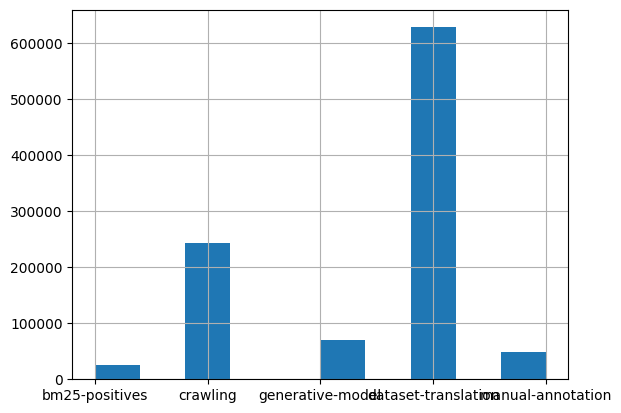

In [7]:
df["passage_source"].hist()

In [8]:
for passage_source in df["passage_source"].unique():
    data_sample = df[df["passage_source"] == passage_source].sample(30, random_state=11)
    path = os.path.join(
        OUTPUT_DIR, f"only_relevant/passage_source_{passage_source}.html"
    )
    os.makedirs(os.path.dirname(path), exist_ok=True)
    data_sample.to_html(path)
    print(path)

notebooks/explore_maupqa.out/only_relevant/passage_source_bm25-positives.html
notebooks/explore_maupqa.out/only_relevant/passage_source_crawling.html
notebooks/explore_maupqa.out/only_relevant/passage_source_generative-model.html
notebooks/explore_maupqa.out/only_relevant/passage_source_dataset-translation.html
notebooks/explore_maupqa.out/only_relevant/passage_source_manual-annotation.html


# Obserwacje

1. Nie wszystkie pytania mają odpowiedzi


/tmp/ipykernel_25787/3458777630.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Has answer", "No answers"])


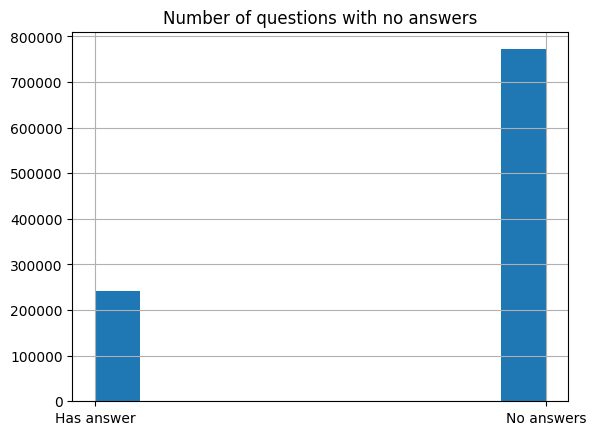

In [9]:
ax = (df["answers"].str.len() == 0).astype(str).hist()
ax.set_title("Number of questions with no answers")
ax.set_xticklabels(["Has answer", "No answers"])
pass

In [10]:
df = df[df["answers"].str.len() > 0]

<Axes: >

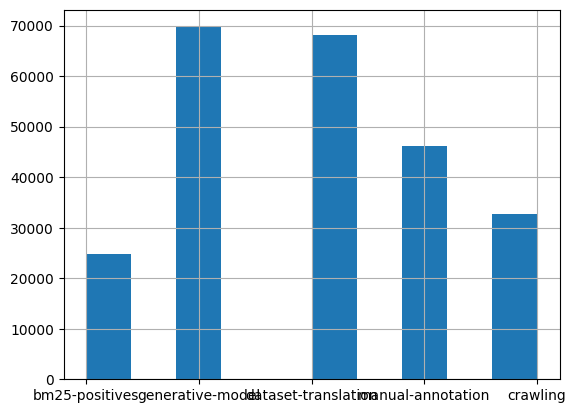

In [11]:
df["passage_source"].hist()

In [12]:
for passage_source in df["passage_source"].unique():
    data_sample = df[df["passage_source"] == passage_source].sample(30, random_state=11)
    path = os.path.join(
        OUTPUT_DIR, f"only_relevant_with_answers/passage_source_{passage_source}.html"
    )
    os.makedirs(os.path.dirname(path), exist_ok=True)
    data_sample.to_html(path)
    print(path)

notebooks/explore_maupqa.out/only_relevant_with_answers/passage_source_bm25-positives.html
notebooks/explore_maupqa.out/only_relevant_with_answers/passage_source_generative-model.html
notebooks/explore_maupqa.out/only_relevant_with_answers/passage_source_dataset-translation.html
notebooks/explore_maupqa.out/only_relevant_with_answers/passage_source_manual-annotation.html
notebooks/explore_maupqa.out/only_relevant_with_answers/passage_source_crawling.html


# Obserwacje

1. BM25 positives zawiera pytania z wiedzy ogólnej o precyzyjnych odpowiedziach
   1. Trzeba ocenić łatwość tworzenia trójek
2. generative-model zawiera pytania z wiedzy ogólnej/szczegółowej, ale o długich i rozmytych odpowiedziach; zawiera pytania bezpośrednio wyprowadzone z pasażu
3. Dataset translation zawiera pytania tak/nie oparte na pasażu, gdzie pasaż i pytanie semantycznie wydają się być te same, różnią się tylko trybem (orzekający/pytający)
4. Manual annotation prezentuje pojedyncze pytanie pochodzące prosto z długiego pasażu, zawierającego potencjalnie dużo trójek.
5. Crawling ma podobną charakterystykę co BM25, ale ma dłuższe pasaże


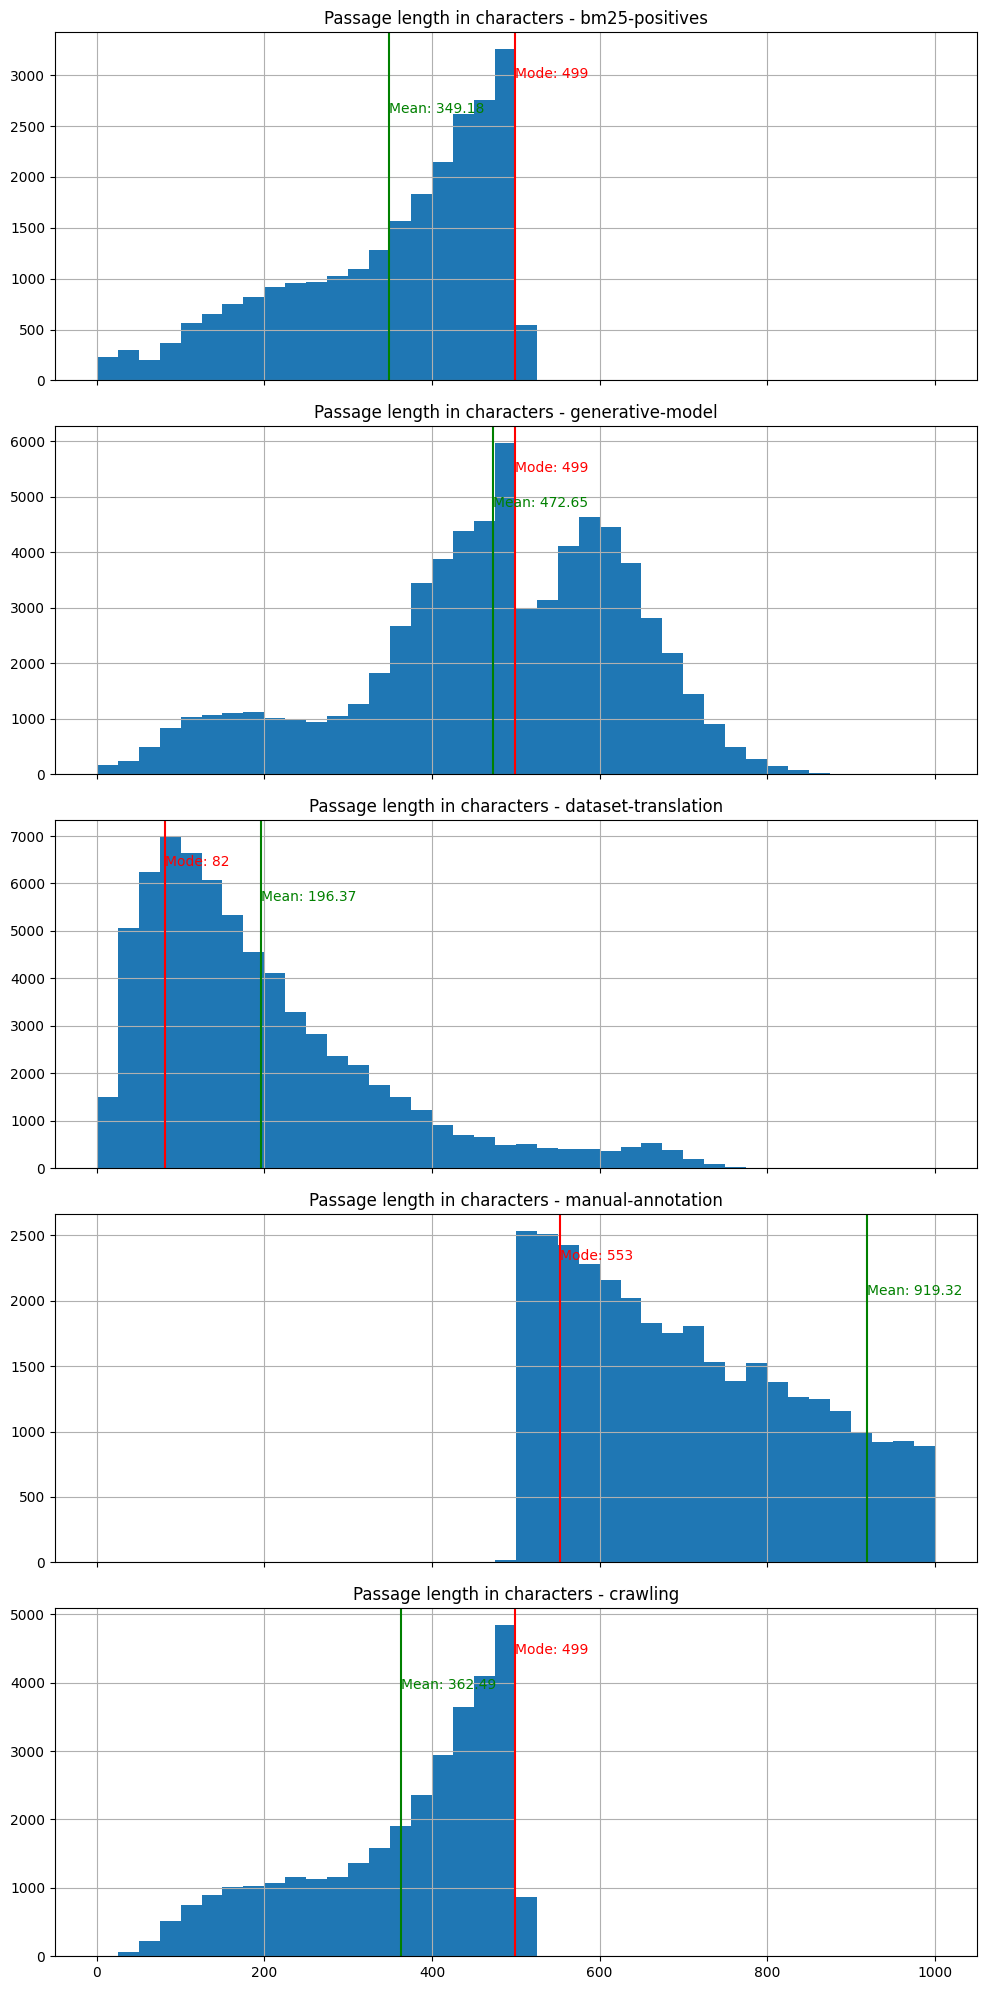

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(df["passage_source"].unique()), sharex=True)
for index, passage_source in enumerate(df["passage_source"].unique()):
    df[df["passage_source"] == passage_source]["passage_text"].str.len().hist(
        bins=40,
        ax=ax[index],
        range=(0, 1000),
    )

    ax[index].set_title("Passage length in characters - " + passage_source)
    mode = (
        df[df["passage_source"] == passage_source]["passage_text"]
        .str.len()
        .mode()
        .item()
    )
    ax[index].axvline(mode, color="red")
    ax[index].text(
        mode,
        ax[index].get_ylim()[1] * 0.9,
        f"Mode: {mode}",
        color="red",
        ha="left",
        va="top",
    )
    mean = (
        df[df["passage_source"] == passage_source]["passage_text"]
        .str.len()
        .mean()
        .item()
    )
    ax[index].axvline(mean, color="green")
    ax[index].text(
        mean,
        ax[index].get_ylim()[1] * 0.8,
        f"Mean: {mean:.2f}",
        color="green",
        ha="left",
        va="top",
    )


fig.set_size_inches(10, 20)
fig.tight_layout()

/tmp/ipykernel_25787/2255461939.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


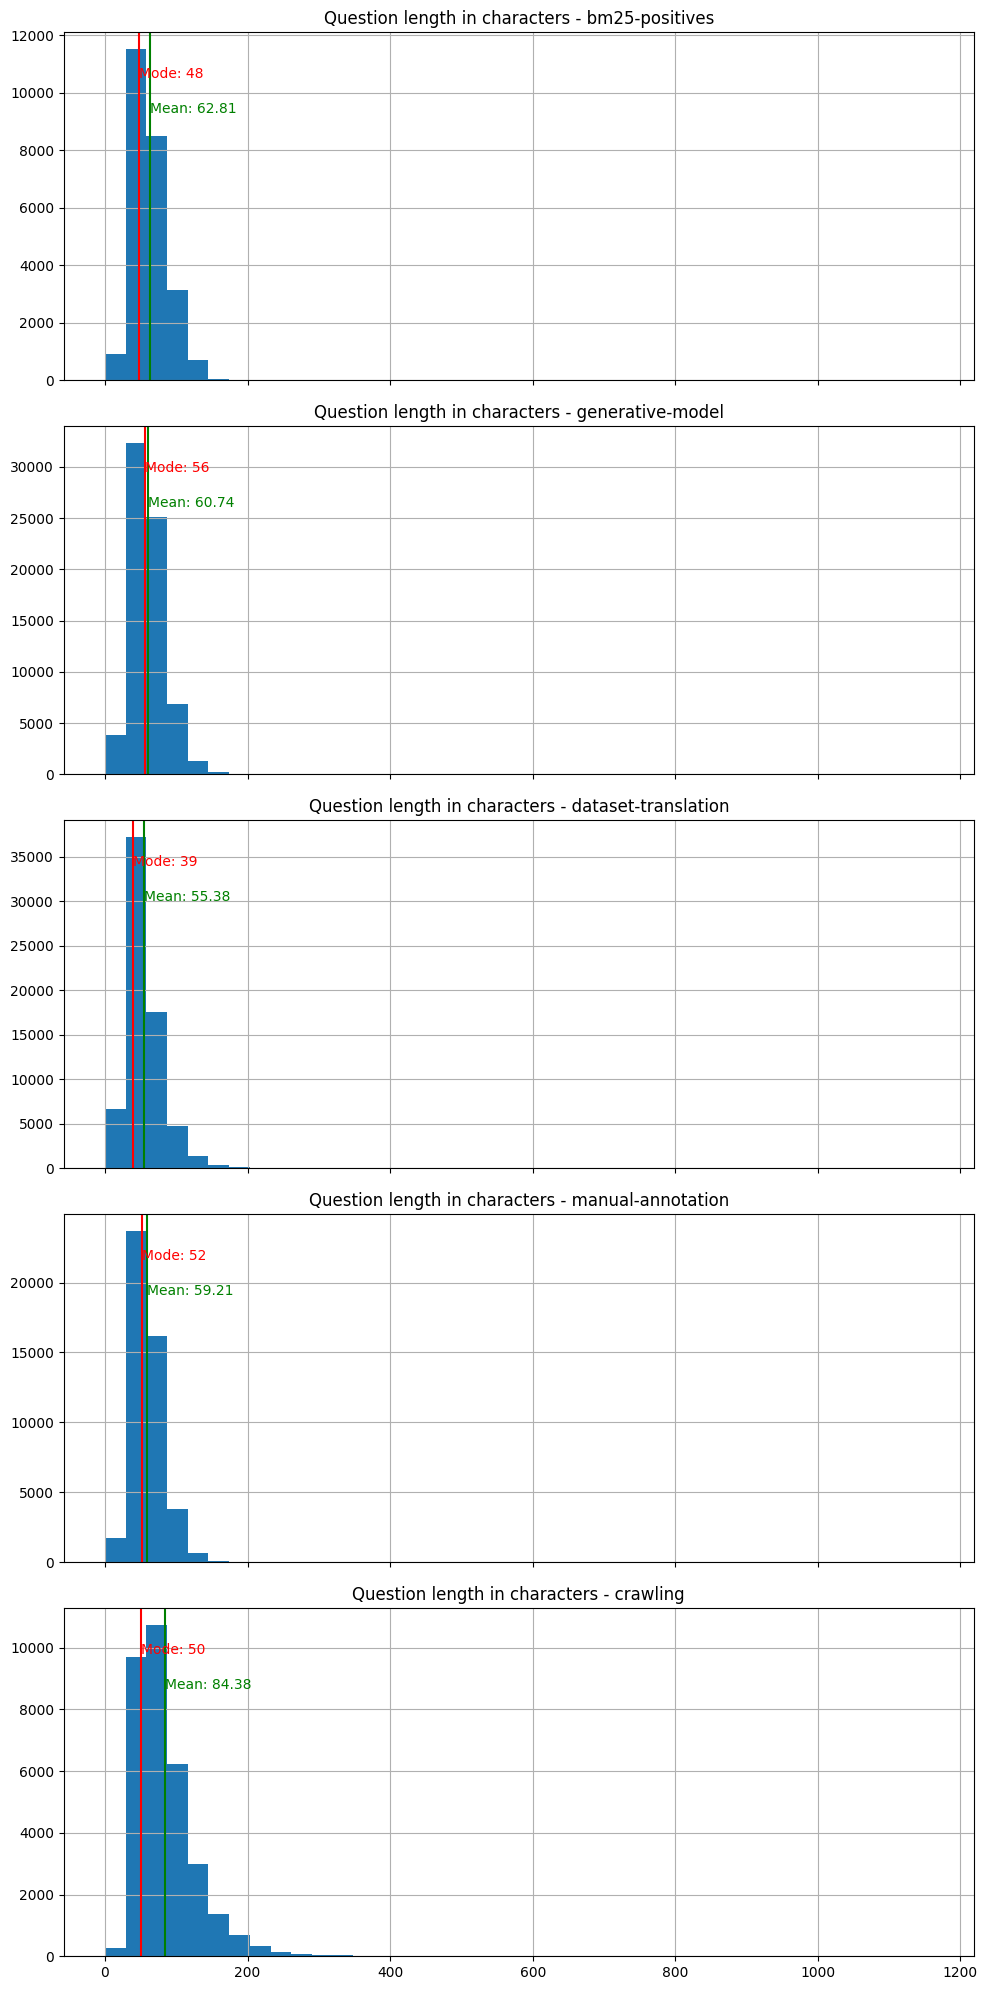

In [14]:
fig, ax = plt.subplots(nrows=len(df["passage_source"].unique()), sharex=True)
for index, passage_source in enumerate(df["passage_source"].unique()):
    df[df["passage_source"] == passage_source]["question"].str.len().hist(
        ax=ax[index], range=(0, np.max(df["question"].str.len())), bins=40
    )
    ax[index].set_title("Question length in characters - " + passage_source)
    mode = (
        df[df["passage_source"] == passage_source]["question"].str.len().mode().item()
    )
    ax[index].axvline(mode, color="red")
    ax[index].text(
        mode,
        ax[index].get_ylim()[1] * 0.9,
        f"Mode: {mode}",
        color="red",
        ha="left",
        va="top",
    )
    mean = (
        df[df["passage_source"] == passage_source]["question"].str.len().mean().item()
    )
    ax[index].axvline(mean, color="green")
    ax[index].text(
        mean,
        ax[index].get_ylim()[1] * 0.8,
        f"Mean: {mean:.2f}",
        color="green",
        ha="left",
        va="top",
    )

fig.set_size_inches(10, 20)
fig.tight_layout()
fig.show()

In [15]:
df_bm25 = df[df["passage_source"] == "bm25-positives"].drop_duplicates(
    subset=["question_id"]
)

<Axes: >

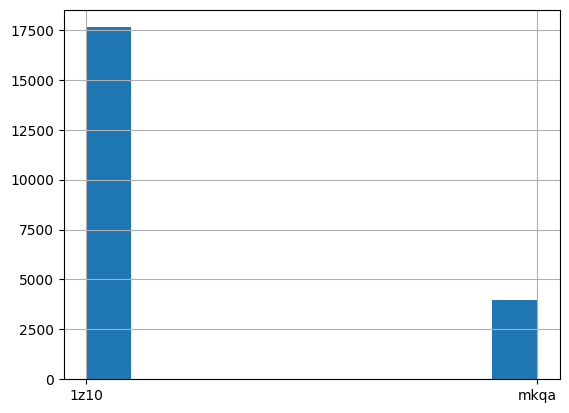

In [16]:
df_bm25["subset"].hist()

In [17]:
bm25_sample = df_bm25[["question", "answers", "passage_text"]].sample(
    30, random_state=11
)
path = os.path.join(OUTPUT_DIR, f"bm25_sample.html")
os.makedirs(os.path.dirname(path), exist_ok=True)
bm25_sample.to_html(path)
print(path)

notebooks/explore_maupqa.out/bm25_sample.html


# Obserwacje

1. Nie wszystkie pasaże realnie zawierają informację, która jest obecna w pytaniu/odpowiedzi (index = 122320)


In [18]:
df_man_annotation = df[df["passage_source"] == "manual-annotation"].drop_duplicates(
    subset=["question_id"]
)

<Axes: >

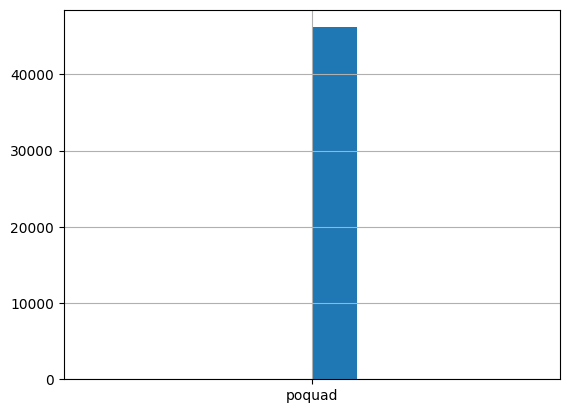

In [19]:
df_man_annotation.subset.hist()

In [20]:
df_man_annotation_sample = df_man_annotation.sample(30, random_state=11)
path = os.path.join(OUTPUT_DIR, f"manual_annotation_sample.html")
os.makedirs(os.path.dirname(path), exist_ok=True)
df_man_annotation_sample.to_html(path)
print(path)

notebooks/explore_maupqa.out/manual_annotation_sample.html


# Obserwacje i plany

1. Manual annotation nadaje się do konstrukcji datasetu (tekst, trójki)
